## Реализация метрики MRR

In [17]:
import timeit

import pandas as pd
import numba as nb
import numpy as np

from matplotlib import pyplot as plt

In [2]:
np.random.seed(23)

### :rocket: Загружаем данные

In [19]:
!mkdir data

mkdir: невозможно создать каталог «data»: Файл существует


In [20]:
!wget https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip -O data/data_original.zip

--2022-12-05 04:58:08--  https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip
Распознаётся storage.yandexcloud.net (storage.yandexcloud.net)… 213.180.193.243, 2a02:6b8::1d9
Подключение к storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 78795385 (75M) [application/zip]
Сохранение в: ‘data/data_original.zip’

data/data_original. 100%[===================>]  75,14M  4,34MB/s    за 14s     

2022-12-05 04:58:23 (5,28 MB/s) - ‘data/data_original.zip’ сохранён [78795385/78795385]



In [22]:
!unzip data/data_original.zip -d data

Archive:  data/data_original.zip
   creating: data/kion_train/
  inflating: data/kion_train/interactions.csv  
  inflating: data/__MACOSX/kion_train/._interactions.csv  
  inflating: data/kion_train/users.csv  
  inflating: data/__MACOSX/kion_train/._users.csv  
  inflating: data/kion_train/items.csv  
  inflating: data/__MACOSX/kion_train/._items.csv  


In [3]:
interactions = pd.read_csv('data/kion_train/interactions.csv')
users = pd.read_csv('data/kion_train/users.csv')
items = pd.read_csv('data/kion_train/items.csv')

In [4]:
def generate_subsample(users_count, top_k, data=interactions):
    users = np.random.choice(data['user_id'].unique(), users_count, replace=False)
    df = data[data['user_id'].isin(users)].reset_index(drop=True)
    del df['last_watch_dt'], df['total_dur'], df['watched_pct']
    recs = np.random.choice(df['item_id'], size=(users_count, top_k))
    return df, users, recs

### :computer: Считаем метрики

In [5]:
def naive_mrr(target, users, recs):
    mrr = []
    for i, user in enumerate(users):
        user_mrr = 0.0
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                user_mrr = 1 / (j + 1)
                break
        mrr.append(user_mrr)
    return sum(mrr) / len(users)

@nb.njit(cache=True, parallel=True)
def numba_mrr(target, users, recs):
    mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user_mrr = 0.0
        user = users[i]
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                user_mrr = 1 / (j + 1)
                break
        mrr[i] = user_mrr
    return mrr.mean()

def pandas_mrr(df, sample_users, recs):
    k = recs.shape[1]
    df_recs = pd.DataFrame({
        'user_id': np.repeat(sample_users,k),
        'item_id': recs.ravel()
    })
    df_recs['rank'] = df_recs.groupby('user_id').cumcount() + 1
    df_merge = df_recs.merge(df, how='inner', on=['user_id','item_id'])
    df_merge['pos_rank'] = df_merge.groupby('user_id').cumcount() + 1
    df_merge = df_merge[df_merge['pos_rank'] == 1]
    df_merge['item_val'] = 1 / df_merge['rank']
    return df_merge['item_val'].sum() / len(sample_users)

In [6]:
users_counts = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]

In [14]:
avg_time_naive = np.zeros((len(users_counts), 5))
avg_time_numba = np.zeros((len(users_counts), 5))
avg_time_pandas = np.zeros((len(users_counts), 5))

In [15]:
for i, count in enumerate(users_counts):
    for j, k in enumerate(top_k):
        df, users, recs = generate_subsample(count, k)
        target = df.values
        n_runs = 5

        print(f'Run naive user_count: {count}, top_k: {k} for {n_runs} times')
        t = timeit.timeit('naive_mrr(target, users, recs)', "from __main__ import naive_mrr, target, users, recs" , number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_naive[i][j] = t / n_runs
              
        print(f'Run numba user_count: {count}, top_k: {k} for {n_runs} times')
        t = timeit.timeit('numba_mrr(target, users, recs)', "from __main__ import numba_mrr, target, users, recs", number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_numba[i][j] = t / n_runs
               
        print(f'Run pandas user_count: {count}, top_k: {k} for {n_runs} times')
        t = timeit.timeit('pandas_mrr(df, users, recs)', "from __main__ import pandas_mrr, df, users, recs", number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_pandas[i][j] = t / n_runs


Run naive user_count: 100, top_k: 10 for 5 times
Avg time: 0.0052 seconds
Run numba user_count: 100, top_k: 10 for 5 times
Avg time: 0.0001 seconds
Run pandas user_count: 100, top_k: 10 for 5 times
Avg time: 0.0075 seconds
Run naive user_count: 100, top_k: 50 for 5 times
Avg time: 0.0142 seconds
Run numba user_count: 100, top_k: 50 for 5 times
Avg time: 0.0002 seconds
Run pandas user_count: 100, top_k: 50 for 5 times
Avg time: 0.0089 seconds
Run naive user_count: 100, top_k: 100 for 5 times
Avg time: 0.0195 seconds
Run numba user_count: 100, top_k: 100 for 5 times
Avg time: 0.0001 seconds
Run pandas user_count: 100, top_k: 100 for 5 times
Avg time: 0.0101 seconds
Run naive user_count: 1000, top_k: 10 for 5 times
Avg time: 0.0540 seconds
Run numba user_count: 1000, top_k: 10 for 5 times
Avg time: 0.0065 seconds
Run pandas user_count: 1000, top_k: 10 for 5 times
Avg time: 0.0092 seconds
Run naive user_count: 1000, top_k: 50 for 5 times
Avg time: 0.1433 seconds
Run numba user_count: 1000,

### :chart_with_upwards_trend: Строим графики

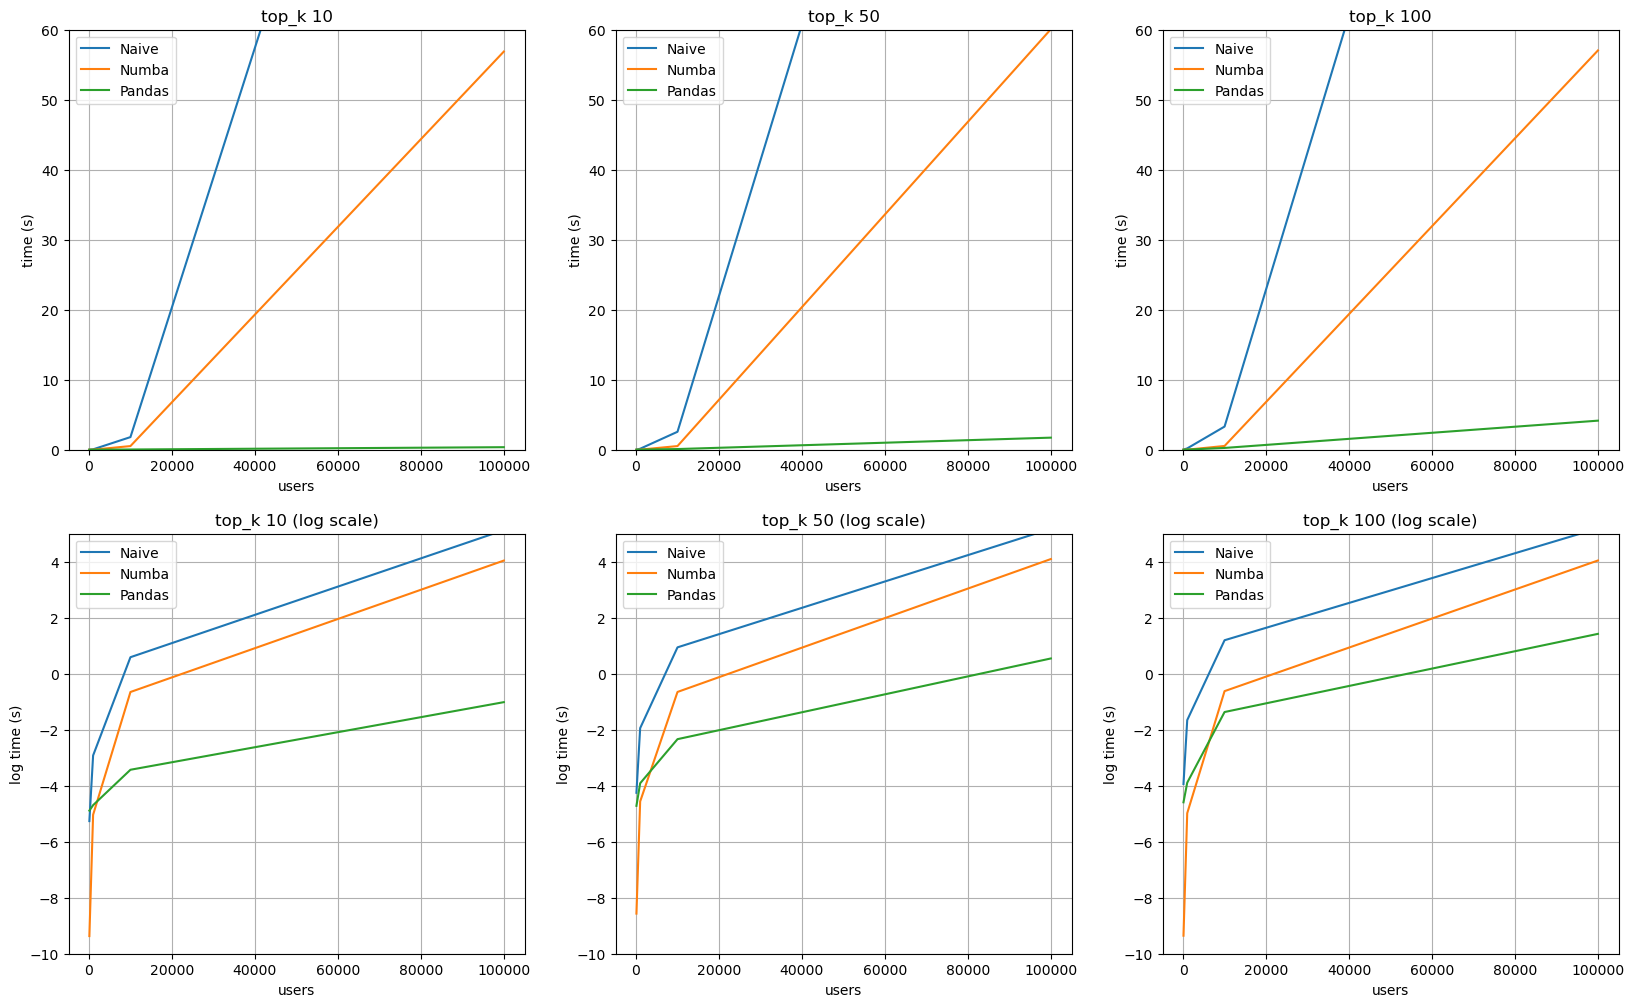

In [18]:

_, ax = plt.subplots(2, 3, figsize=(20, 12))
for i in range(3):
    ax[0][i].plot(users_counts, avg_time_naive[:, i], label='Naive')
    ax[0][i].plot(users_counts, avg_time_numba[:, i], label='Numba')
    ax[0][i].plot(users_counts, avg_time_pandas[:, i], label='Pandas')
    ax[0][i].set_title(f'top_k {top_k[i]}')
    ax[0][i].set_xlabel('users')
    ax[0][i].set_ylabel('time (s)')
    ax[0][i].set_ylim(0, 60)
    ax[0][i].grid()
    ax[0][i].legend()
    
    # log scale
    ax[1][i].plot(users_counts, np.log(avg_time_naive[:, i]), label='Naive')
    ax[1][i].plot(users_counts, np.log(avg_time_numba[:, i]), label='Numba')
    ax[1][i].plot(users_counts, np.log(avg_time_pandas[:, i]), label='Pandas')
    ax[1][i].set_title(f'top_k {top_k[i]} (log scale)')
    ax[1][i].set_xlabel('users')
    ax[1][i].set_ylabel('log time (s)')
    ax[1][i].set_ylim(-10, 5)
    ax[1][i].grid()
    ax[1][i].legend()
plt.show()